In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
import logging
from logging import handlers
from fetch_data import (
    static_population_erva_age,
)
from forward_integration import forward_integration, get_model_parameters
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
erva_pop_file = 'stats/erva_population_age_2020.csv'
number_age_groups = 8
num_ervas = 5
N_p = num_ervas
N_g = number_age_groups
mob_av, beta_gh, pop_erva_hat, age_er, = get_model_parameters(number_age_groups, num_ervas, erva_pop_file)

# number of optimization variables
N_f = (N_g-3)*N_p

In [3]:
# Plot parameters
plot_interval = 15
ervas_labels = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Simulation parameters
t0 = '2021-04-19'
T = 115
# transmission parameter
beta = 0.02
# Number of vaccines per day
u = 30000

In [4]:
policy_thl = False

_, _, _, _, _, D_g, u_g = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy_thl)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_plot = D_g*age_er_prop
u_g_plot = u_g*age_er_prop

Time: 103. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 104. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 105. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 106. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 107. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 108. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 109. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 110. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 111. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 112. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 113. All ERVAs seem to have finished
Susceptibles left: 0.000000.


In [5]:
def plot_ervas(ax, D_g, t0, T, ervas_labels, plot_subject):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ervas == len(ervas_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=0)
    assert deaths.shape[0] == num_ervas
    assert deaths.shape[1] == T
    
    for erva_i in range(num_ervas):
        ax.plot(x, deaths[erva_i, :], label=ervas_labels[erva_i])
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s' % (plot_subject, ))
    ax.set_title('Number of %s per ERVA' % (plot_subject, ))
        
    ax.legend()

In [6]:
def plot_age_groups(ax, D_g, t0, T, age_labels, plot_subject):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=1)
    assert deaths.shape[0] == num_ages
    assert deaths.shape[1] == T
    
    for age_i in range(num_ages):
        ax.plot(x, deaths[age_i, :], label=age_labels[age_i])
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s' % (plot_subject, ))
    ax.set_title('Number of %s per age group' % (plot_subject, ))
        
    ax.legend()

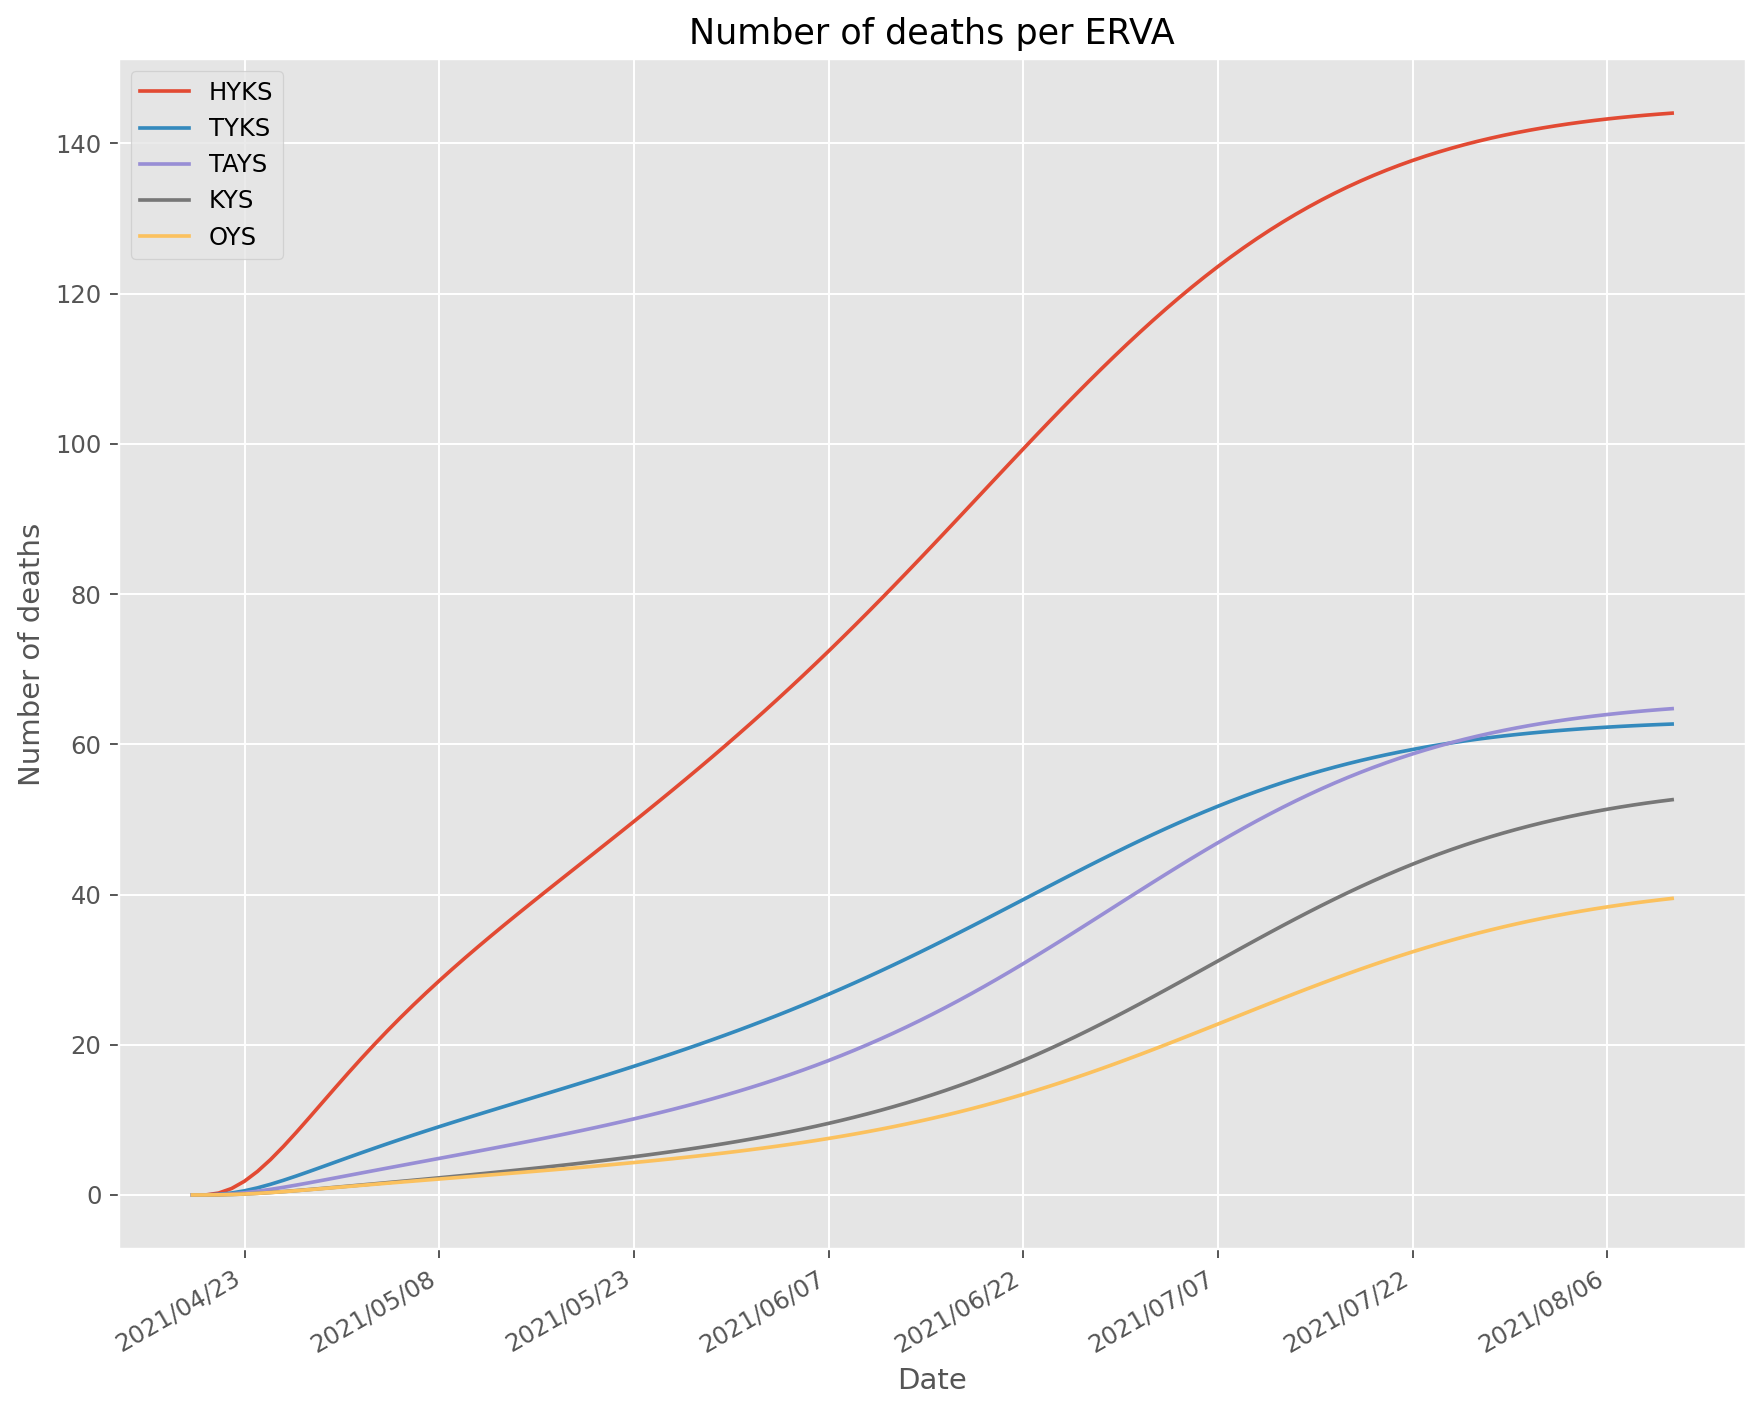

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='deaths')

fig.autofmt_xdate()

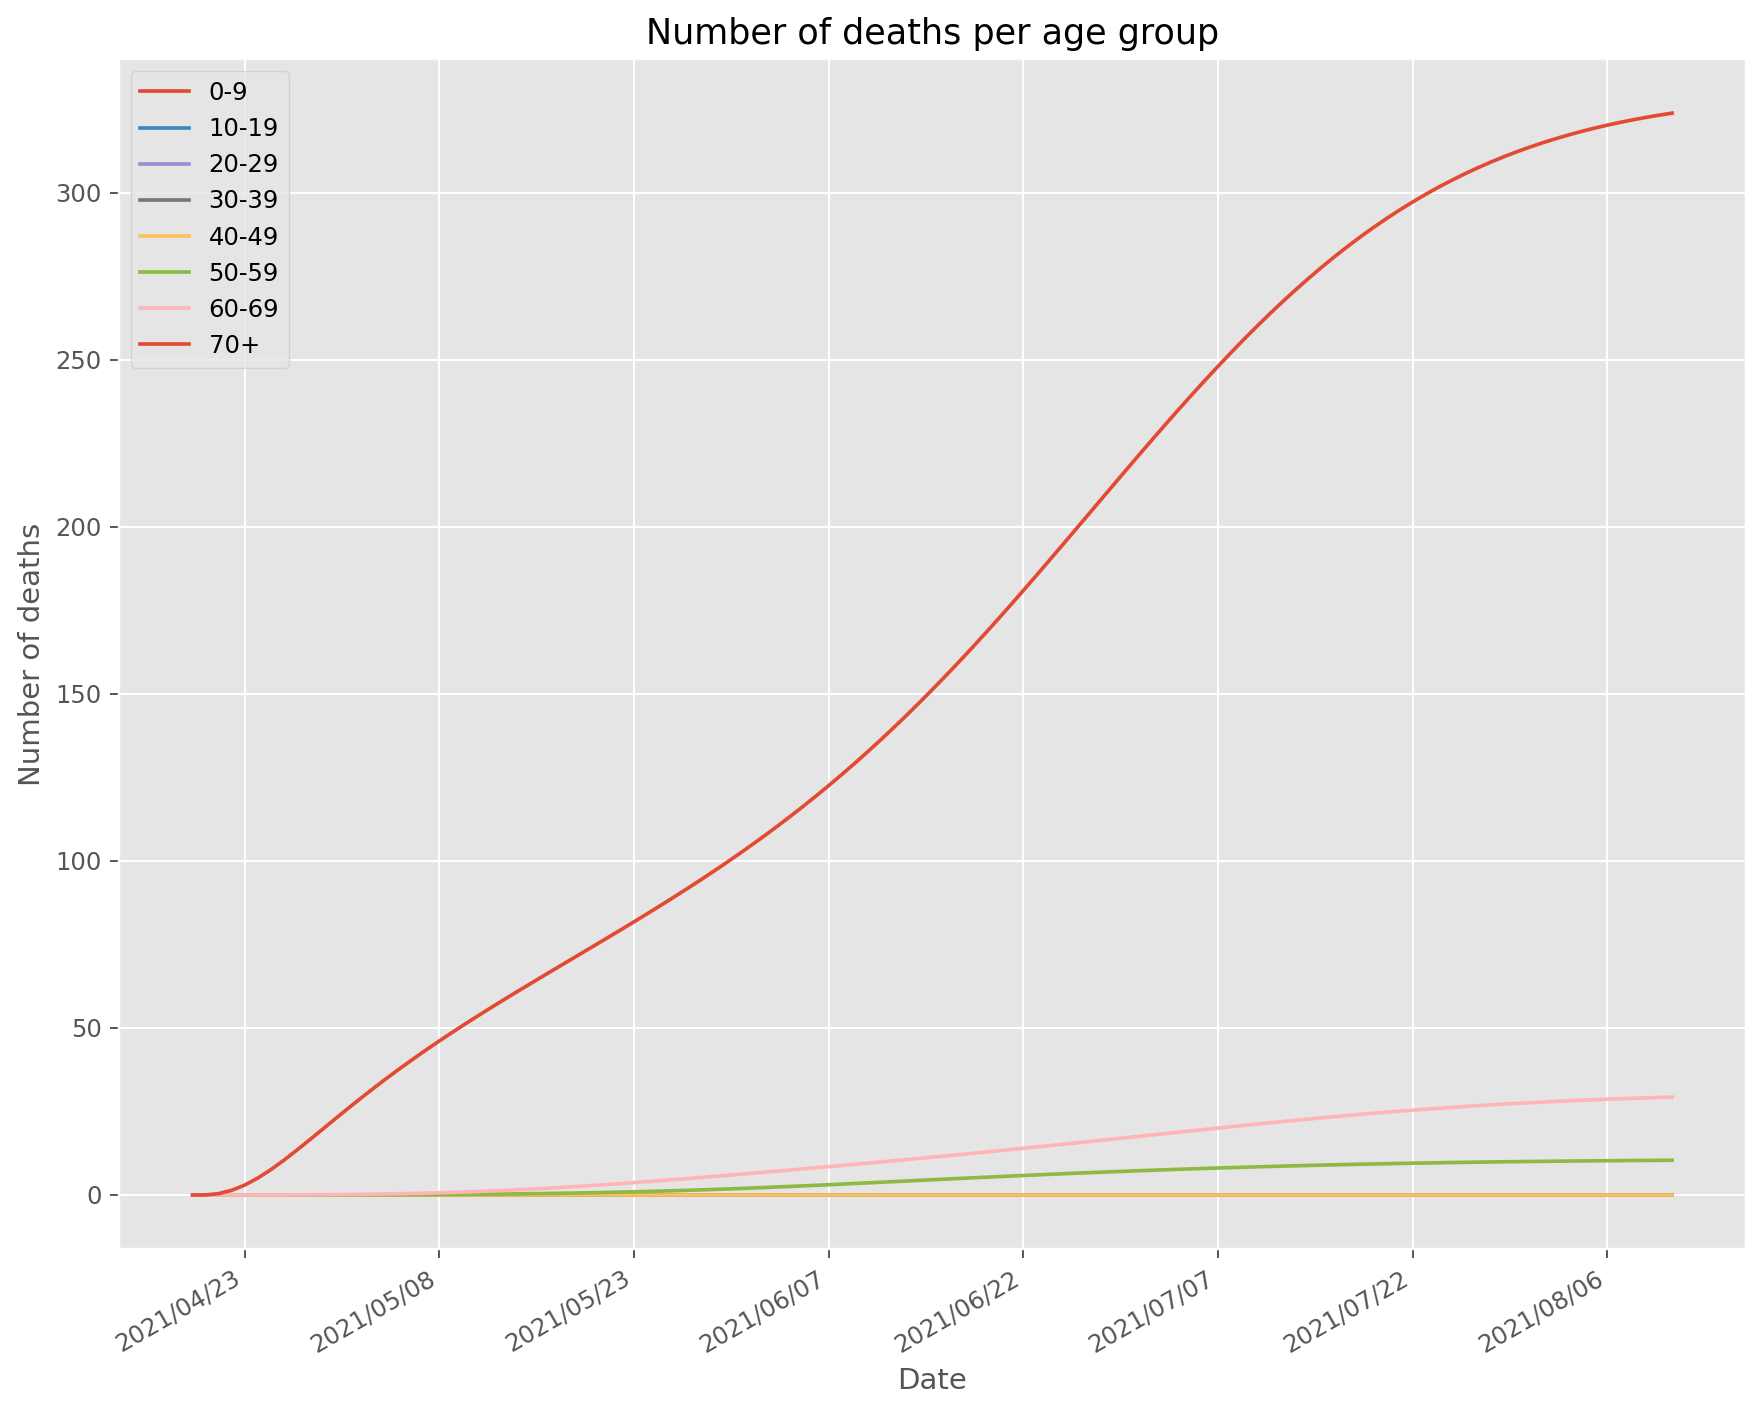

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='deaths')

fig.autofmt_xdate()

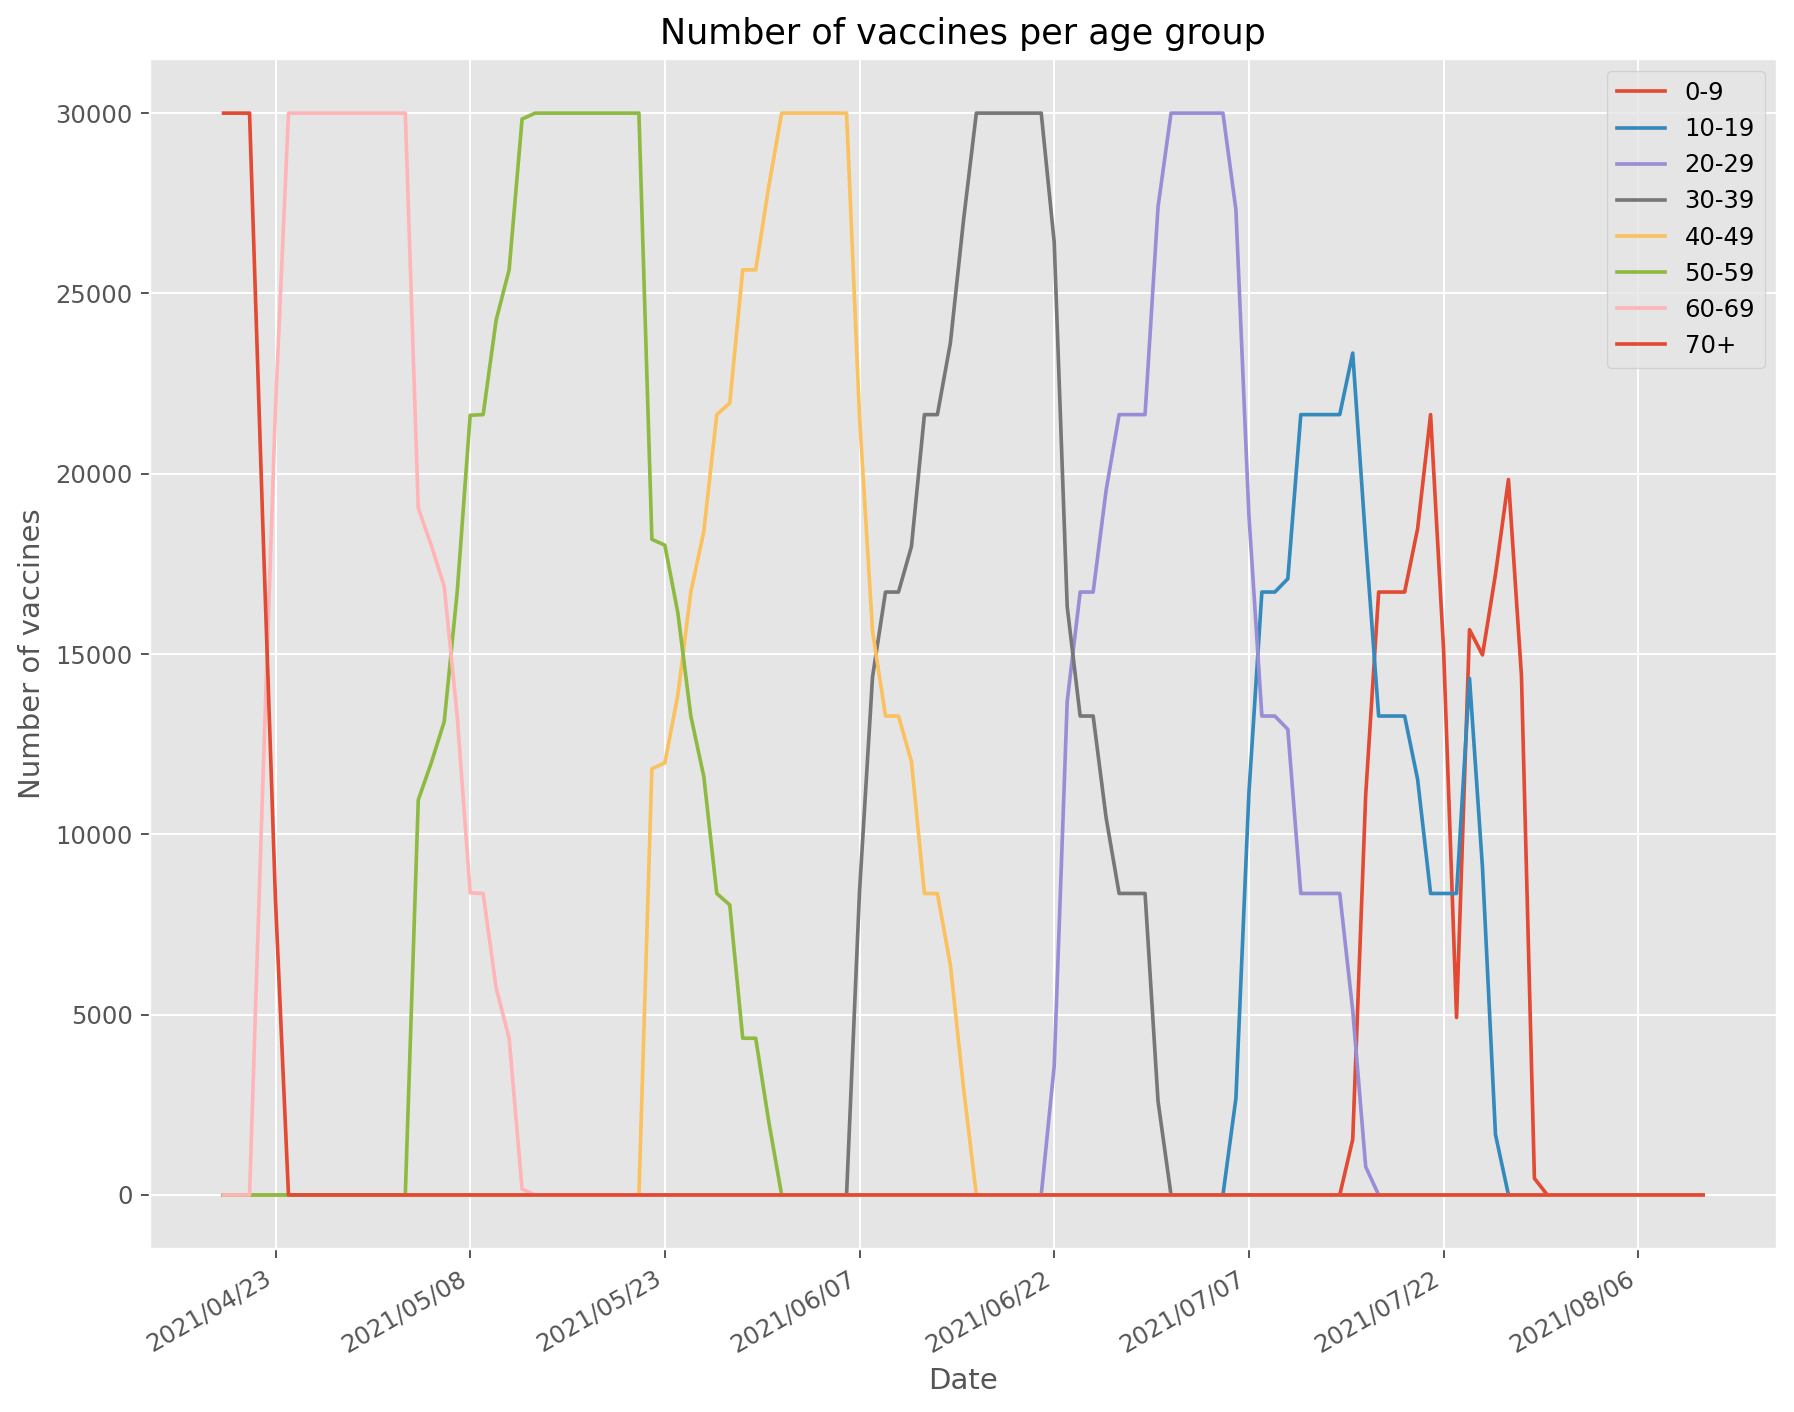

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='vaccines')

fig.autofmt_xdate()

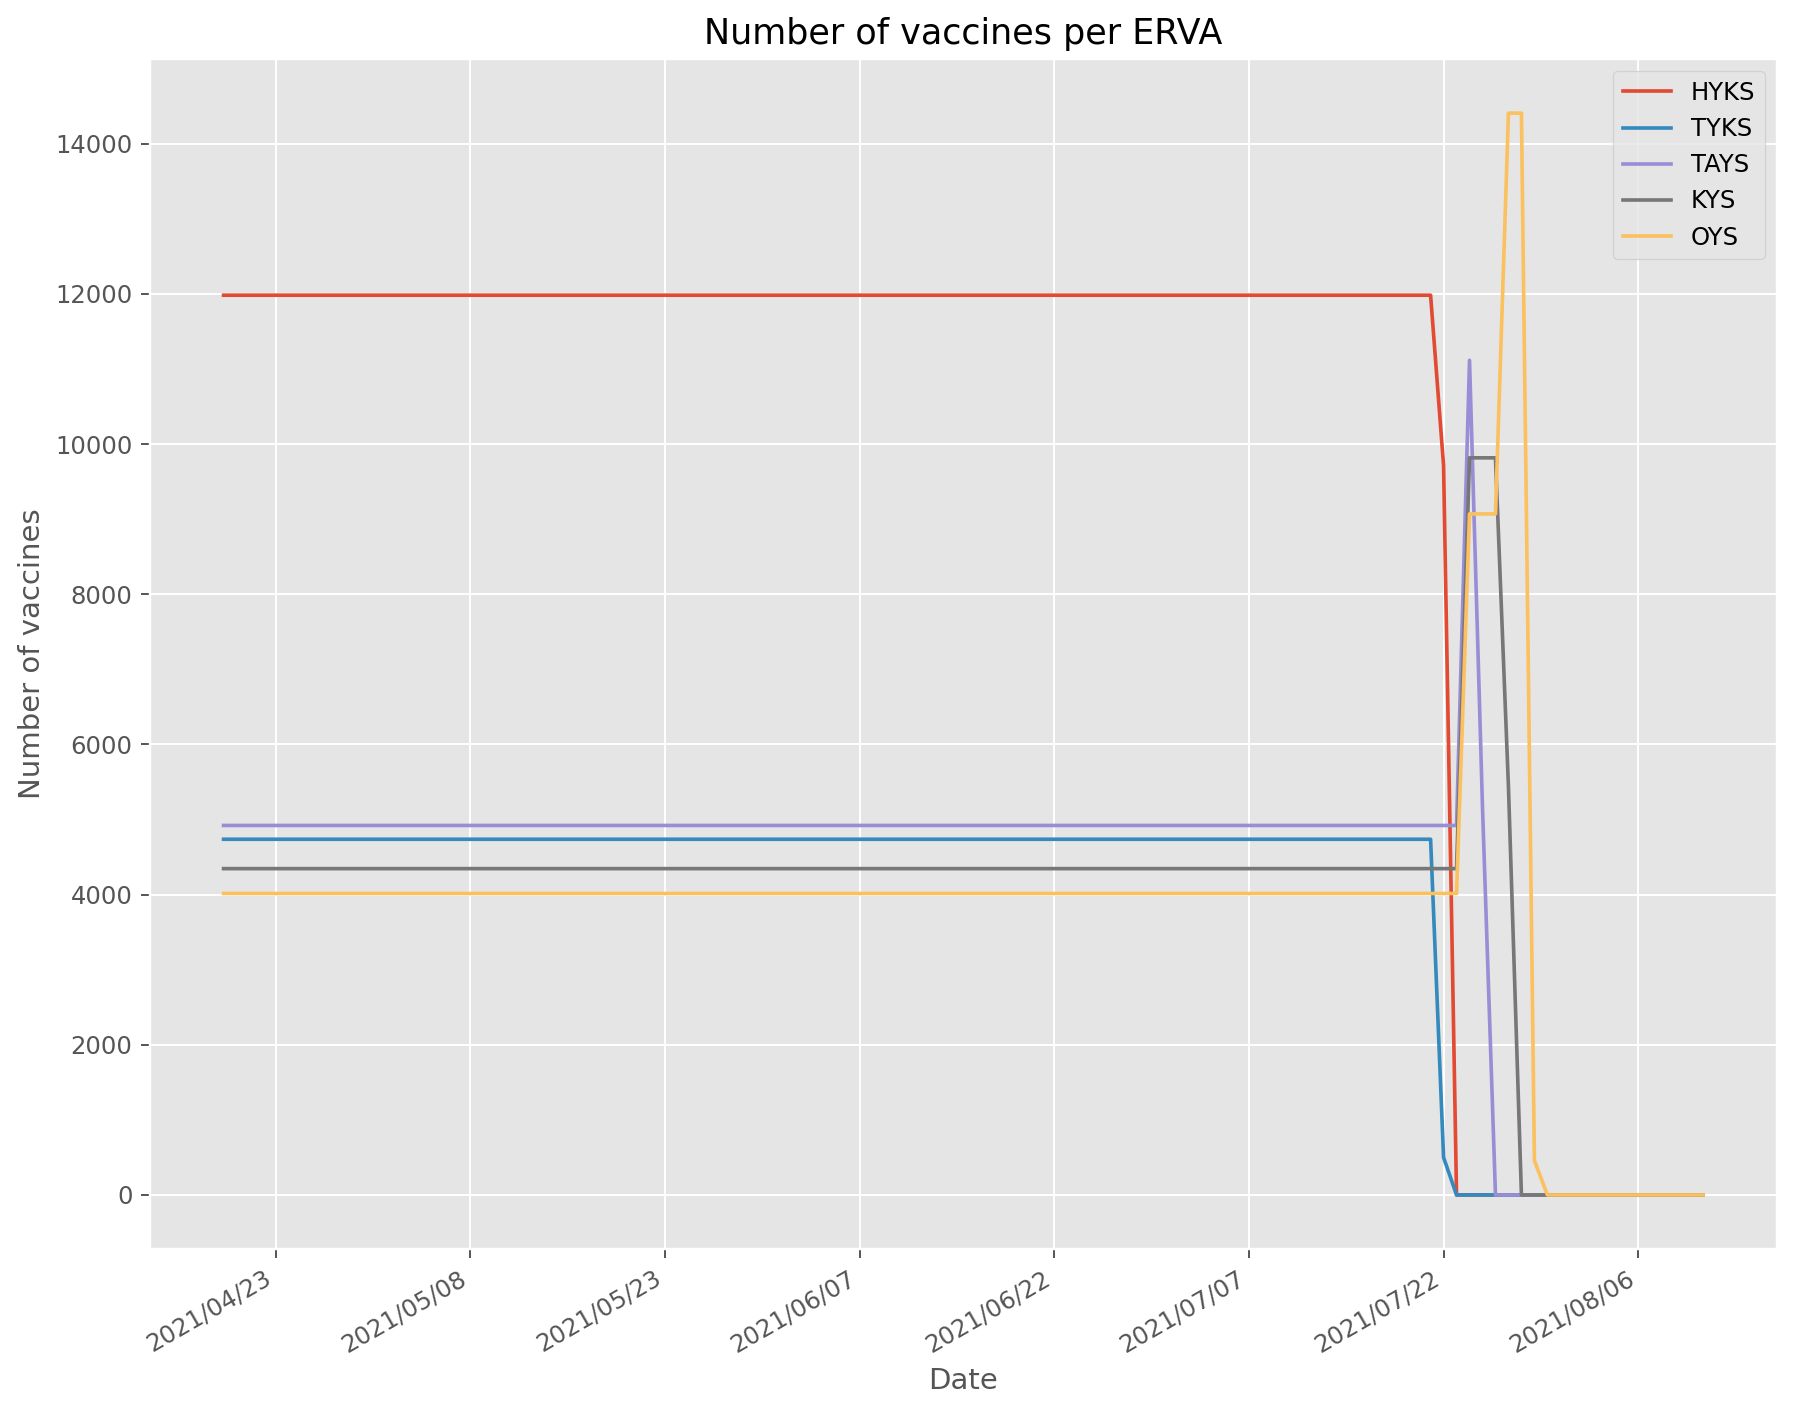

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='vaccines')

fig.autofmt_xdate()

In [11]:
policy_thl = True

_, _, _, _, _, D_g_thl, u_g_thl = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy_thl)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_thl_plot = D_g_thl*age_er_prop
u_g_thl_plot = u_g_thl*age_er_prop

Time: 102. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 103. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 104. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 105. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 106. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 107. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 108. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 109. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 110. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 111. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 112. All ERVAs seem to have finished
Susceptibles left: 0.000000.
Time: 113. All ERVAs seem to have finished
Susceptibles left: 0.000000.


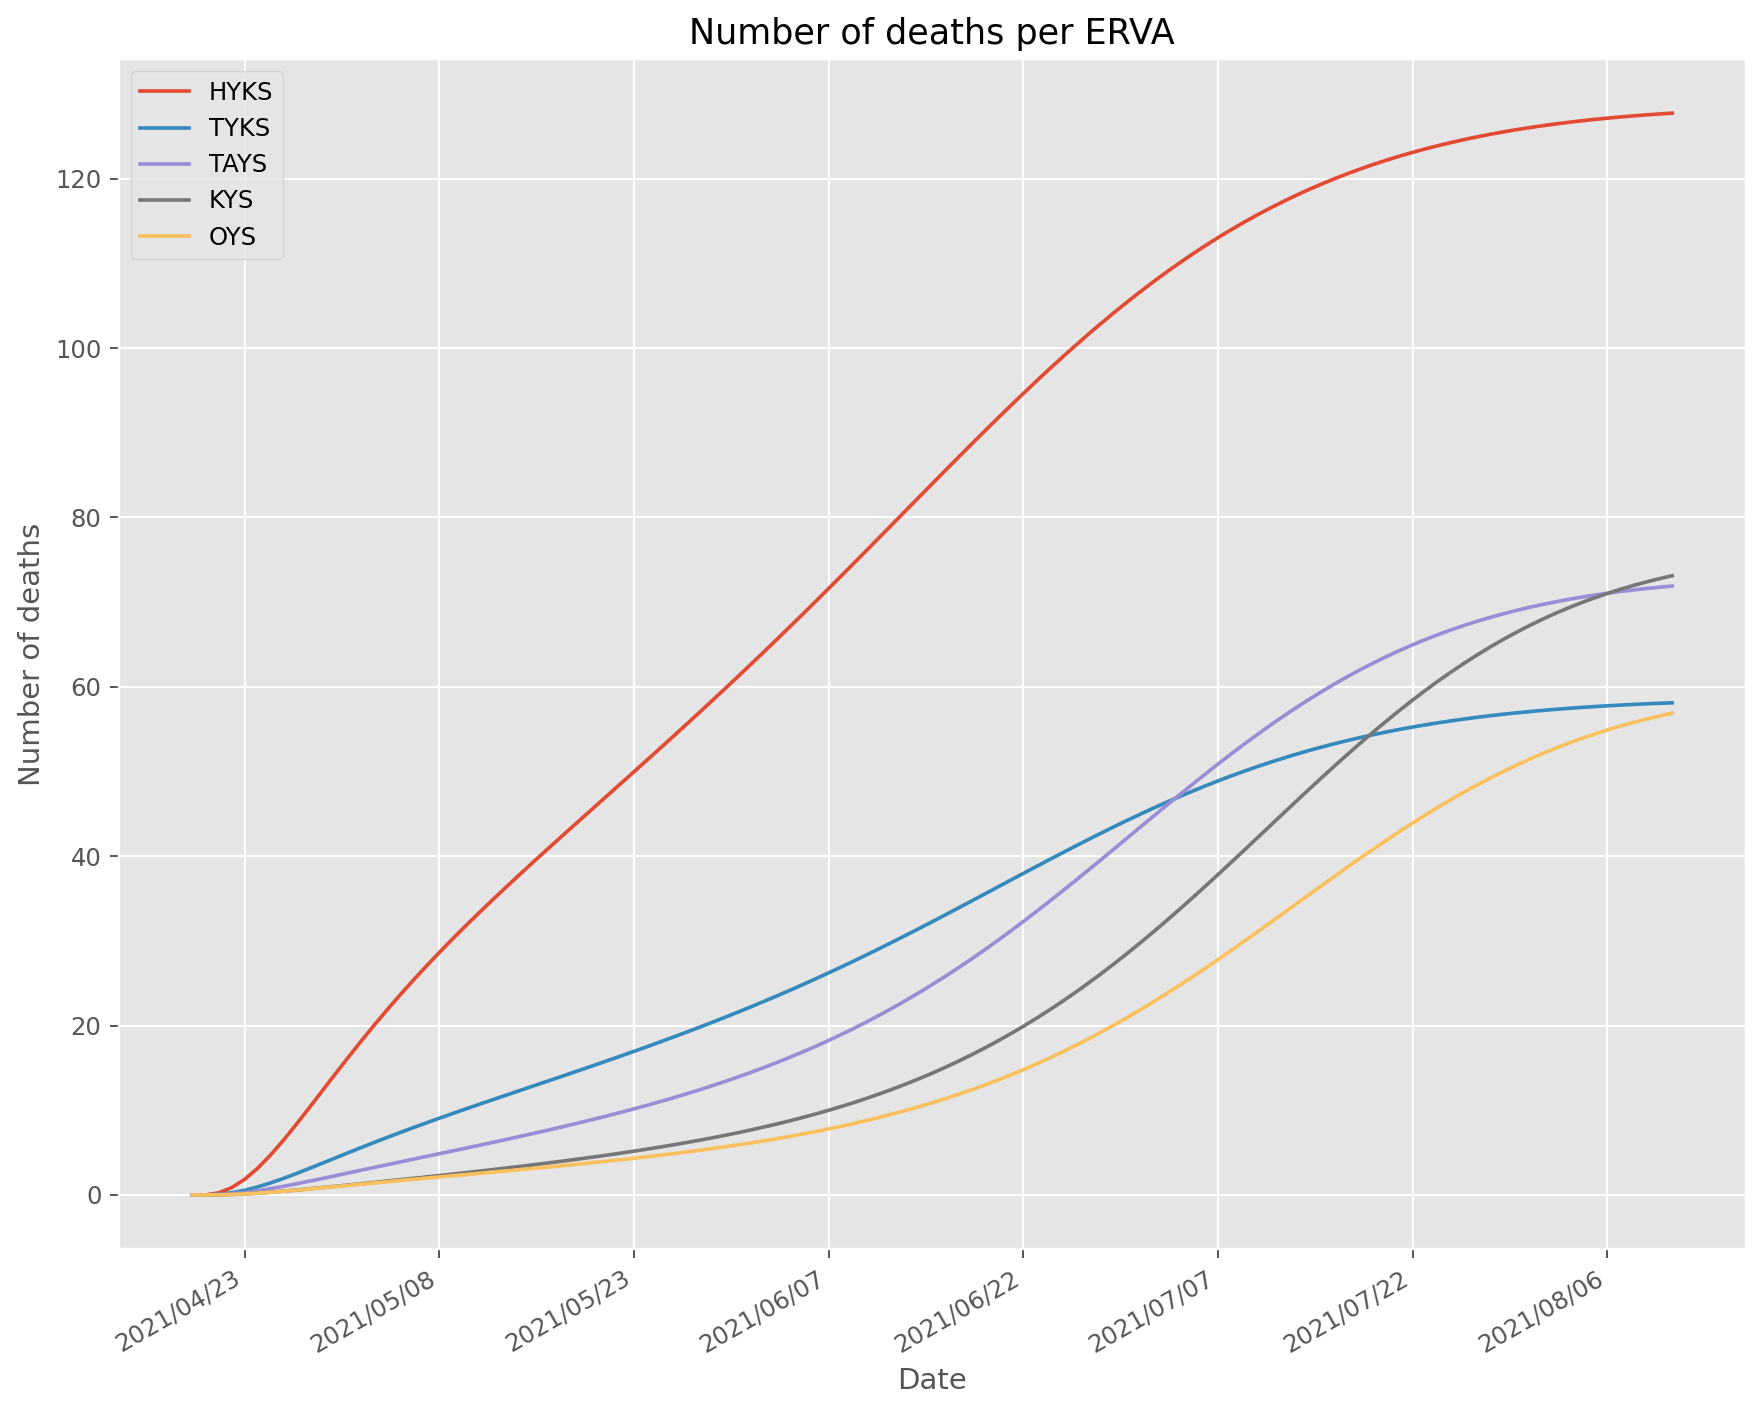

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='deaths')

fig.autofmt_xdate()

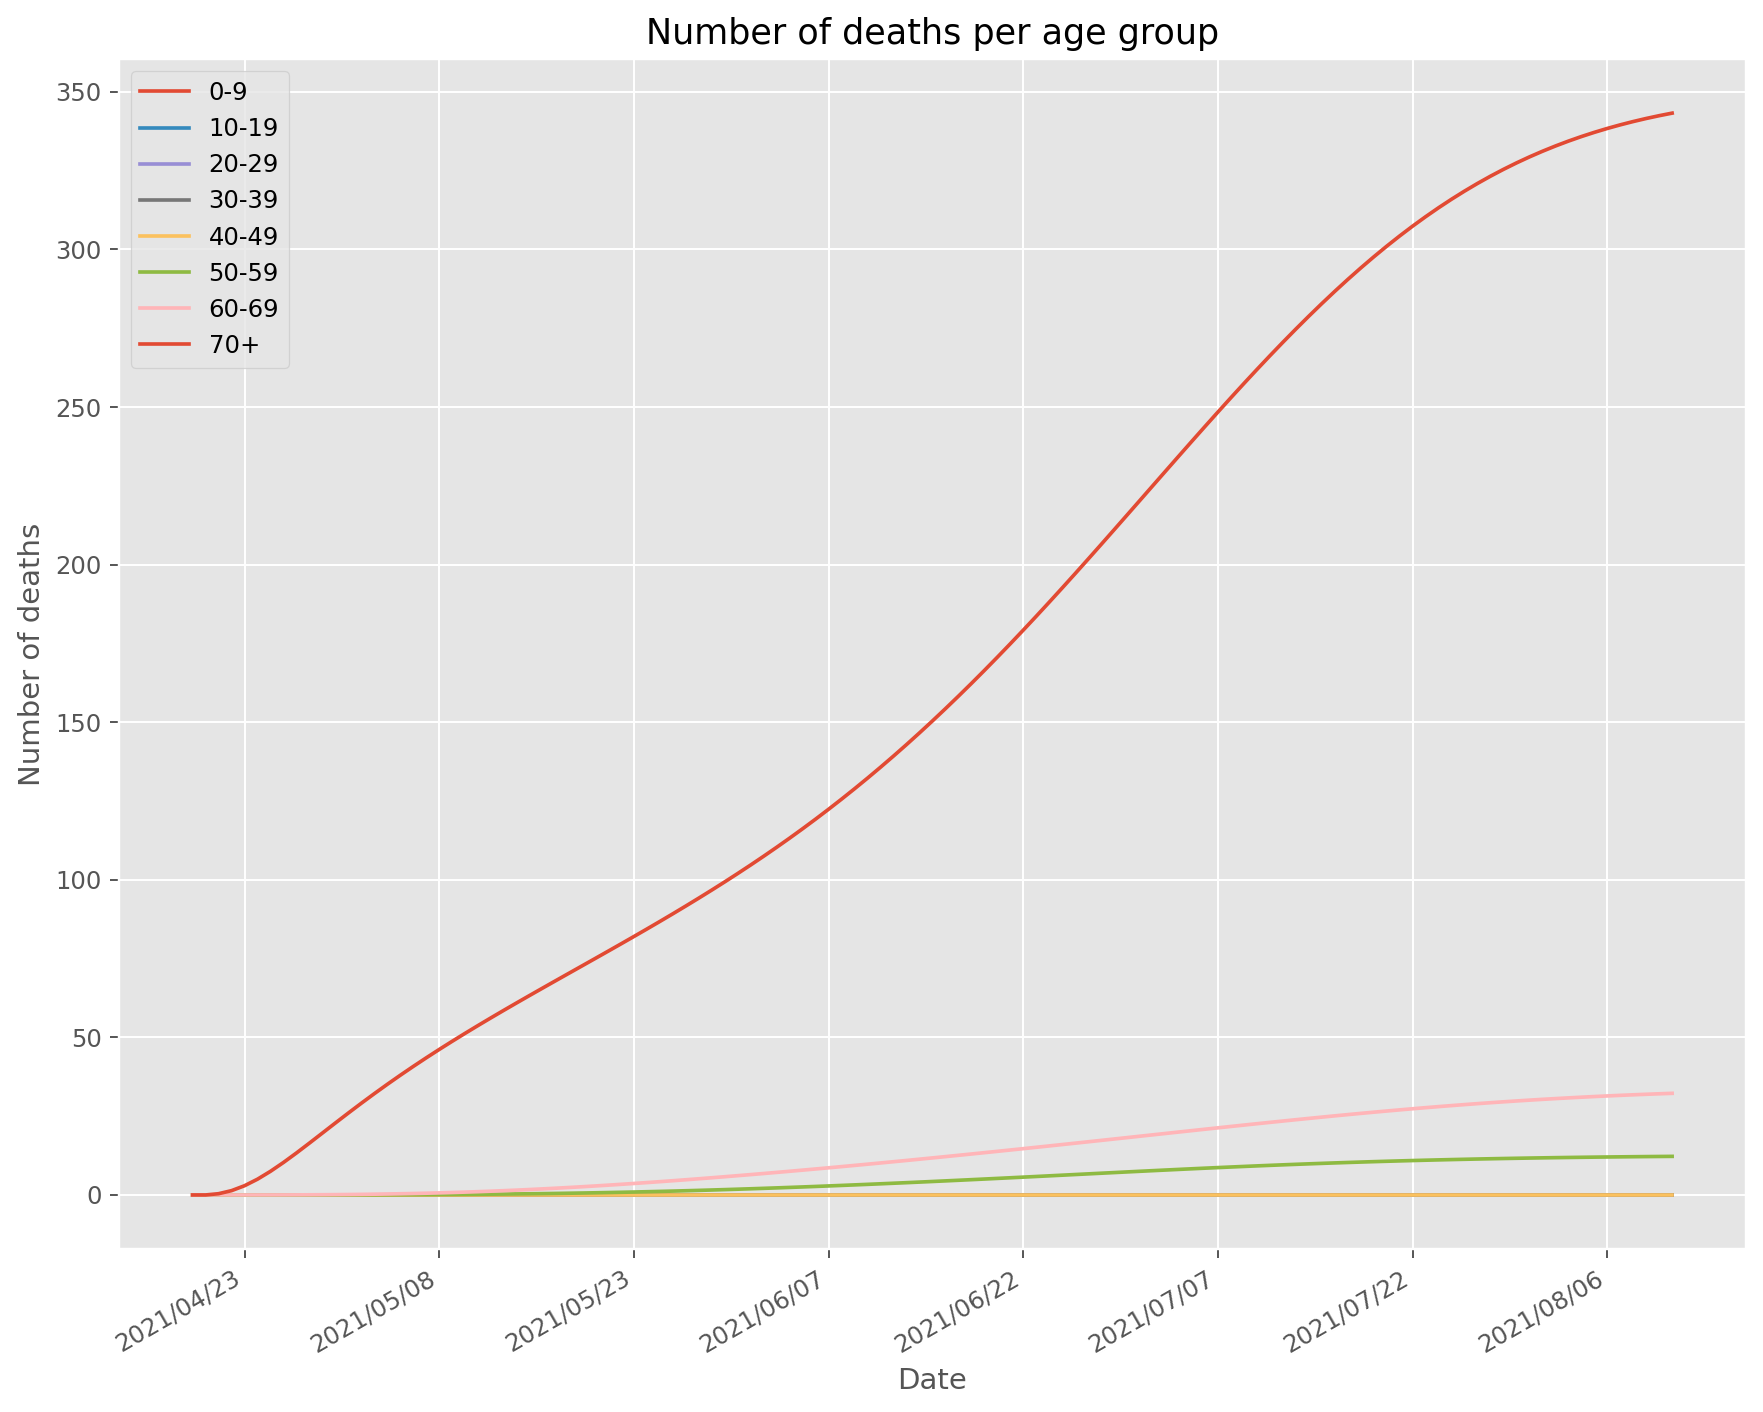

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='deaths')

fig.autofmt_xdate()

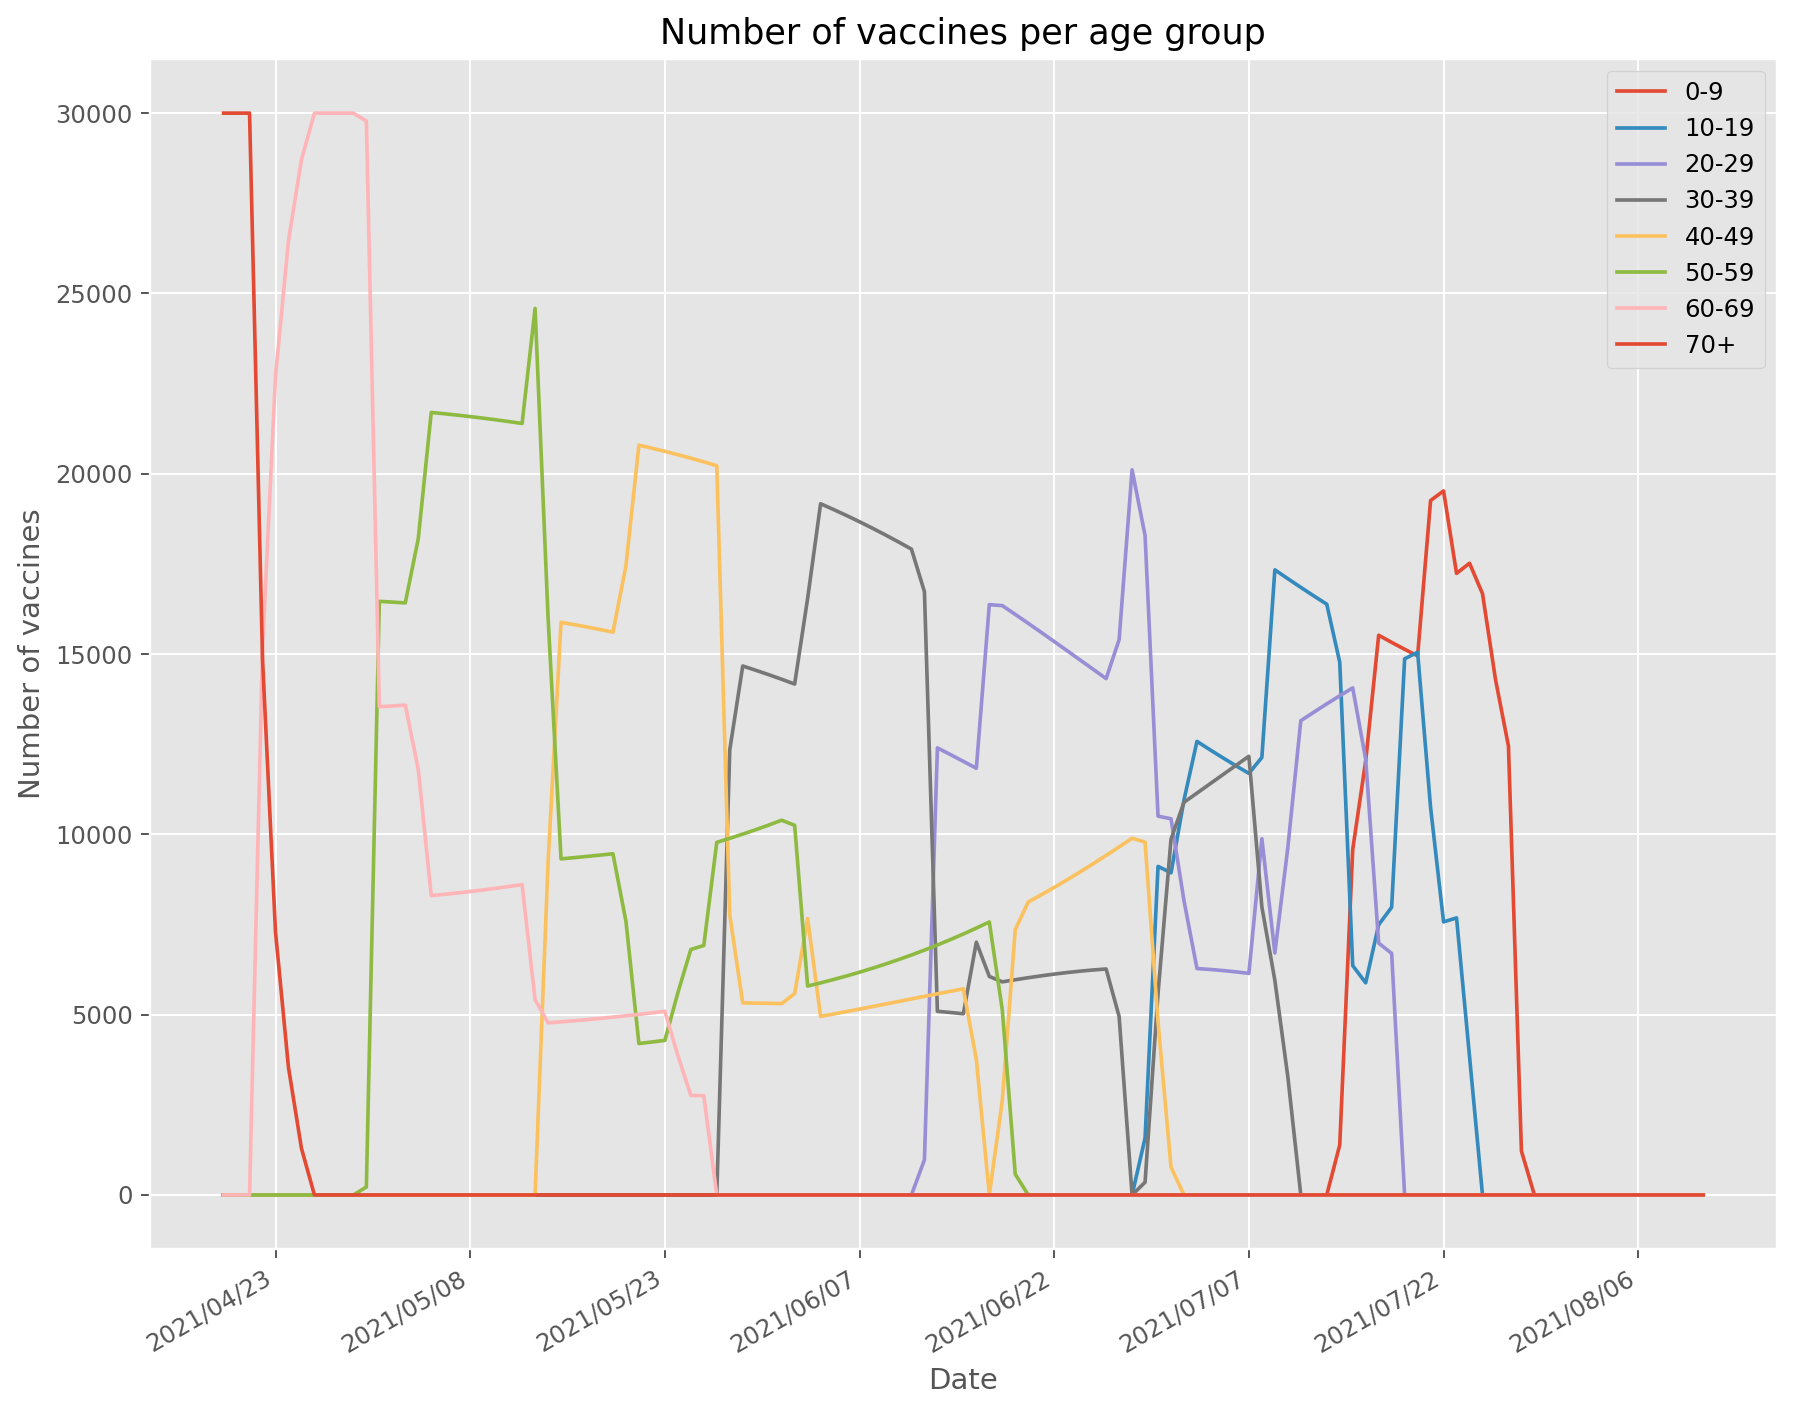

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='vaccines')

fig.autofmt_xdate()

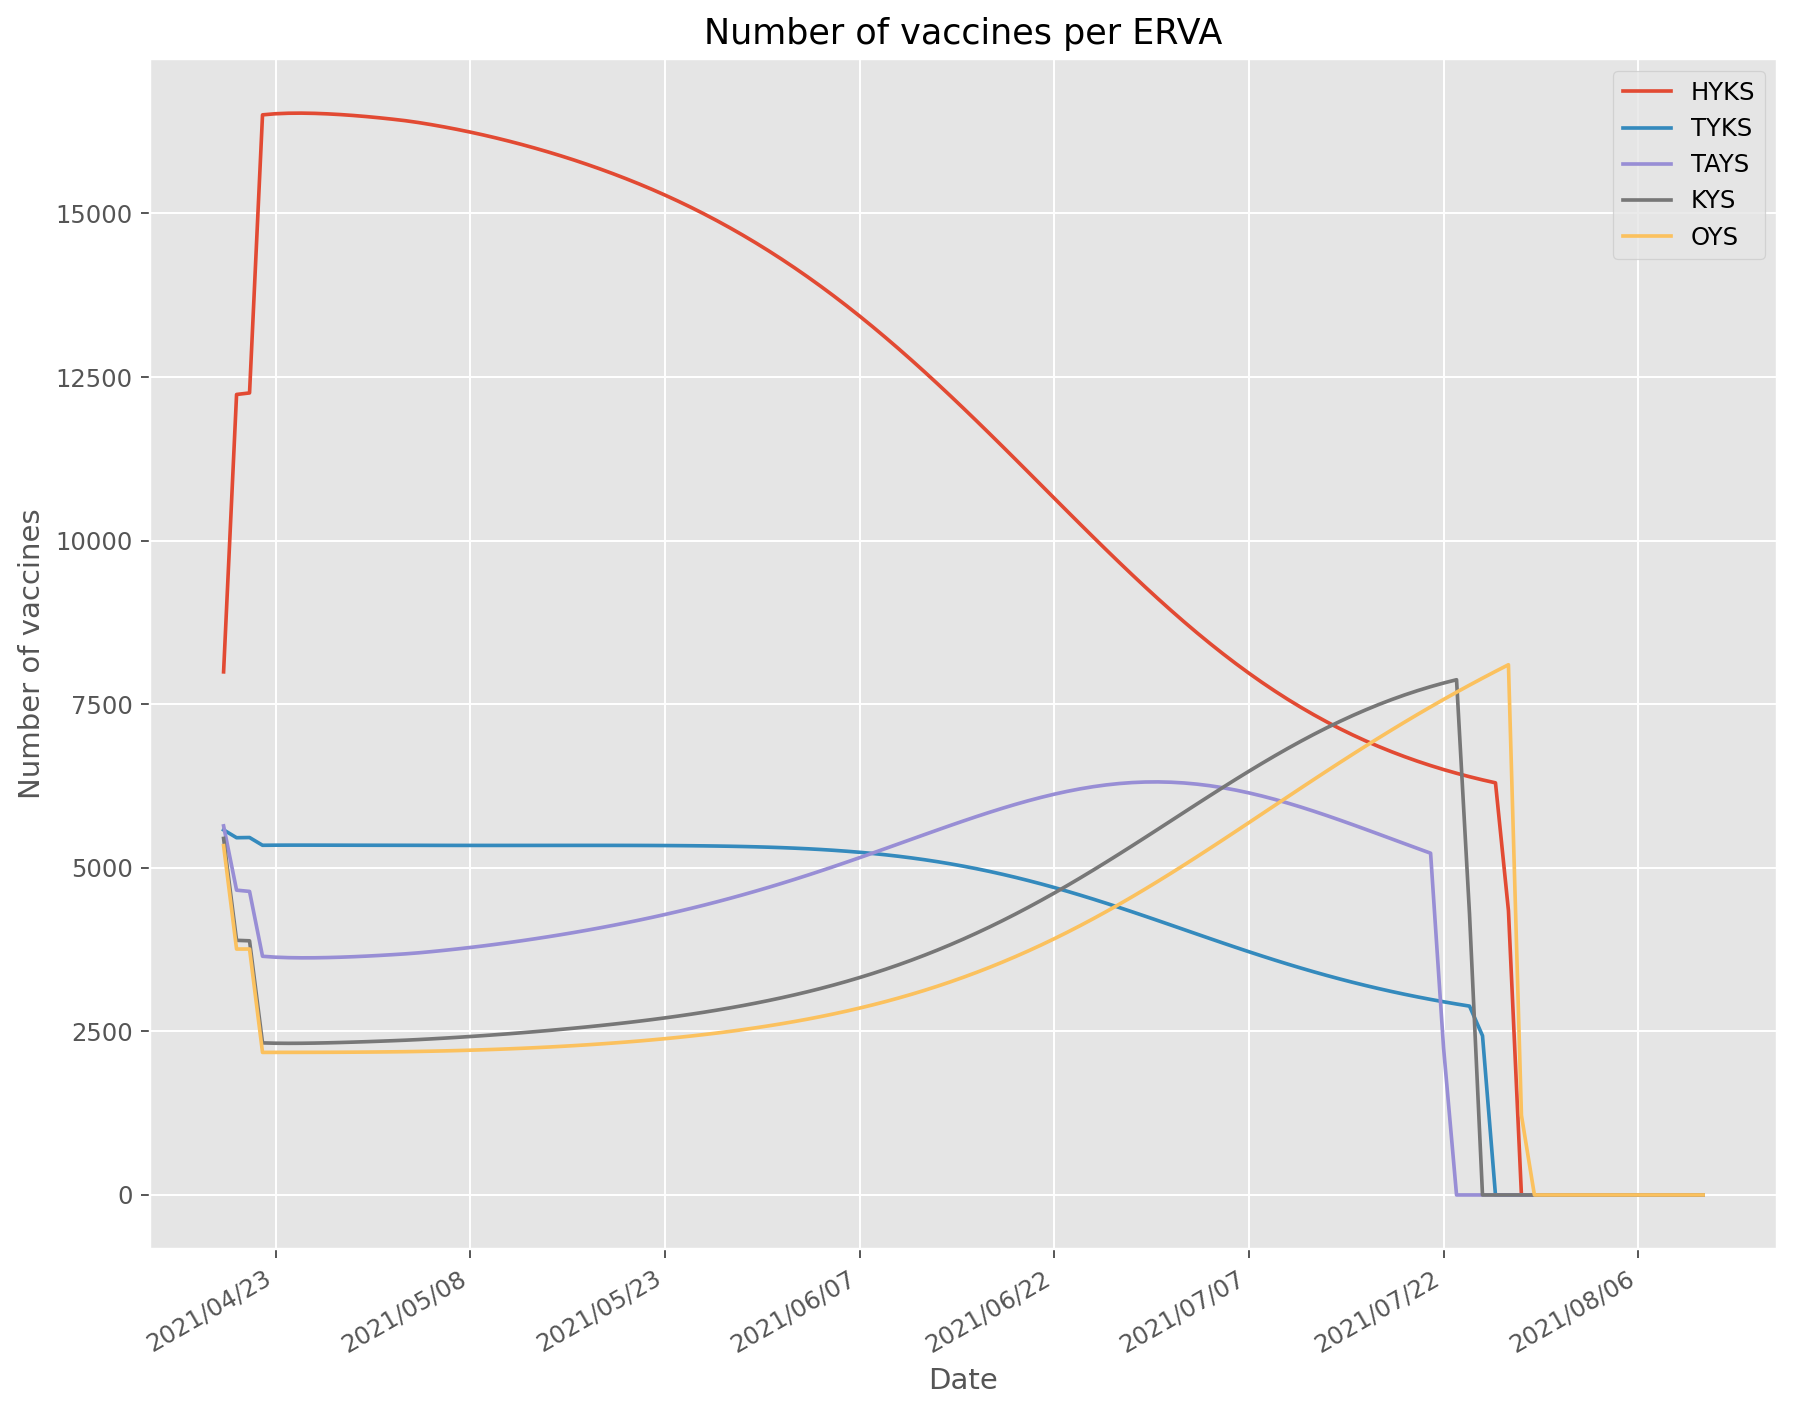

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='vaccines')

fig.autofmt_xdate()

In [16]:
def plot_compare_strategies(ax, D_g, D_g_thl, t0, T):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=1)
    deaths = deaths.sum(axis=0)
    deaths_thl = D_g_thl.sum(axis=1)
    deaths_thl = deaths_thl.sum(axis=0)
    assert deaths.shape == deaths_thl.shape
    assert deaths.shape[0] == T
    
    ax.plot(x, deaths, label='Number of vaccines proportional to population')
    ax.plot(x, deaths_thl, label='THL strategy. Weighted sum')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of deaths')
    ax.set_title('Comparing vaccination strategies')
        
    ax.legend()

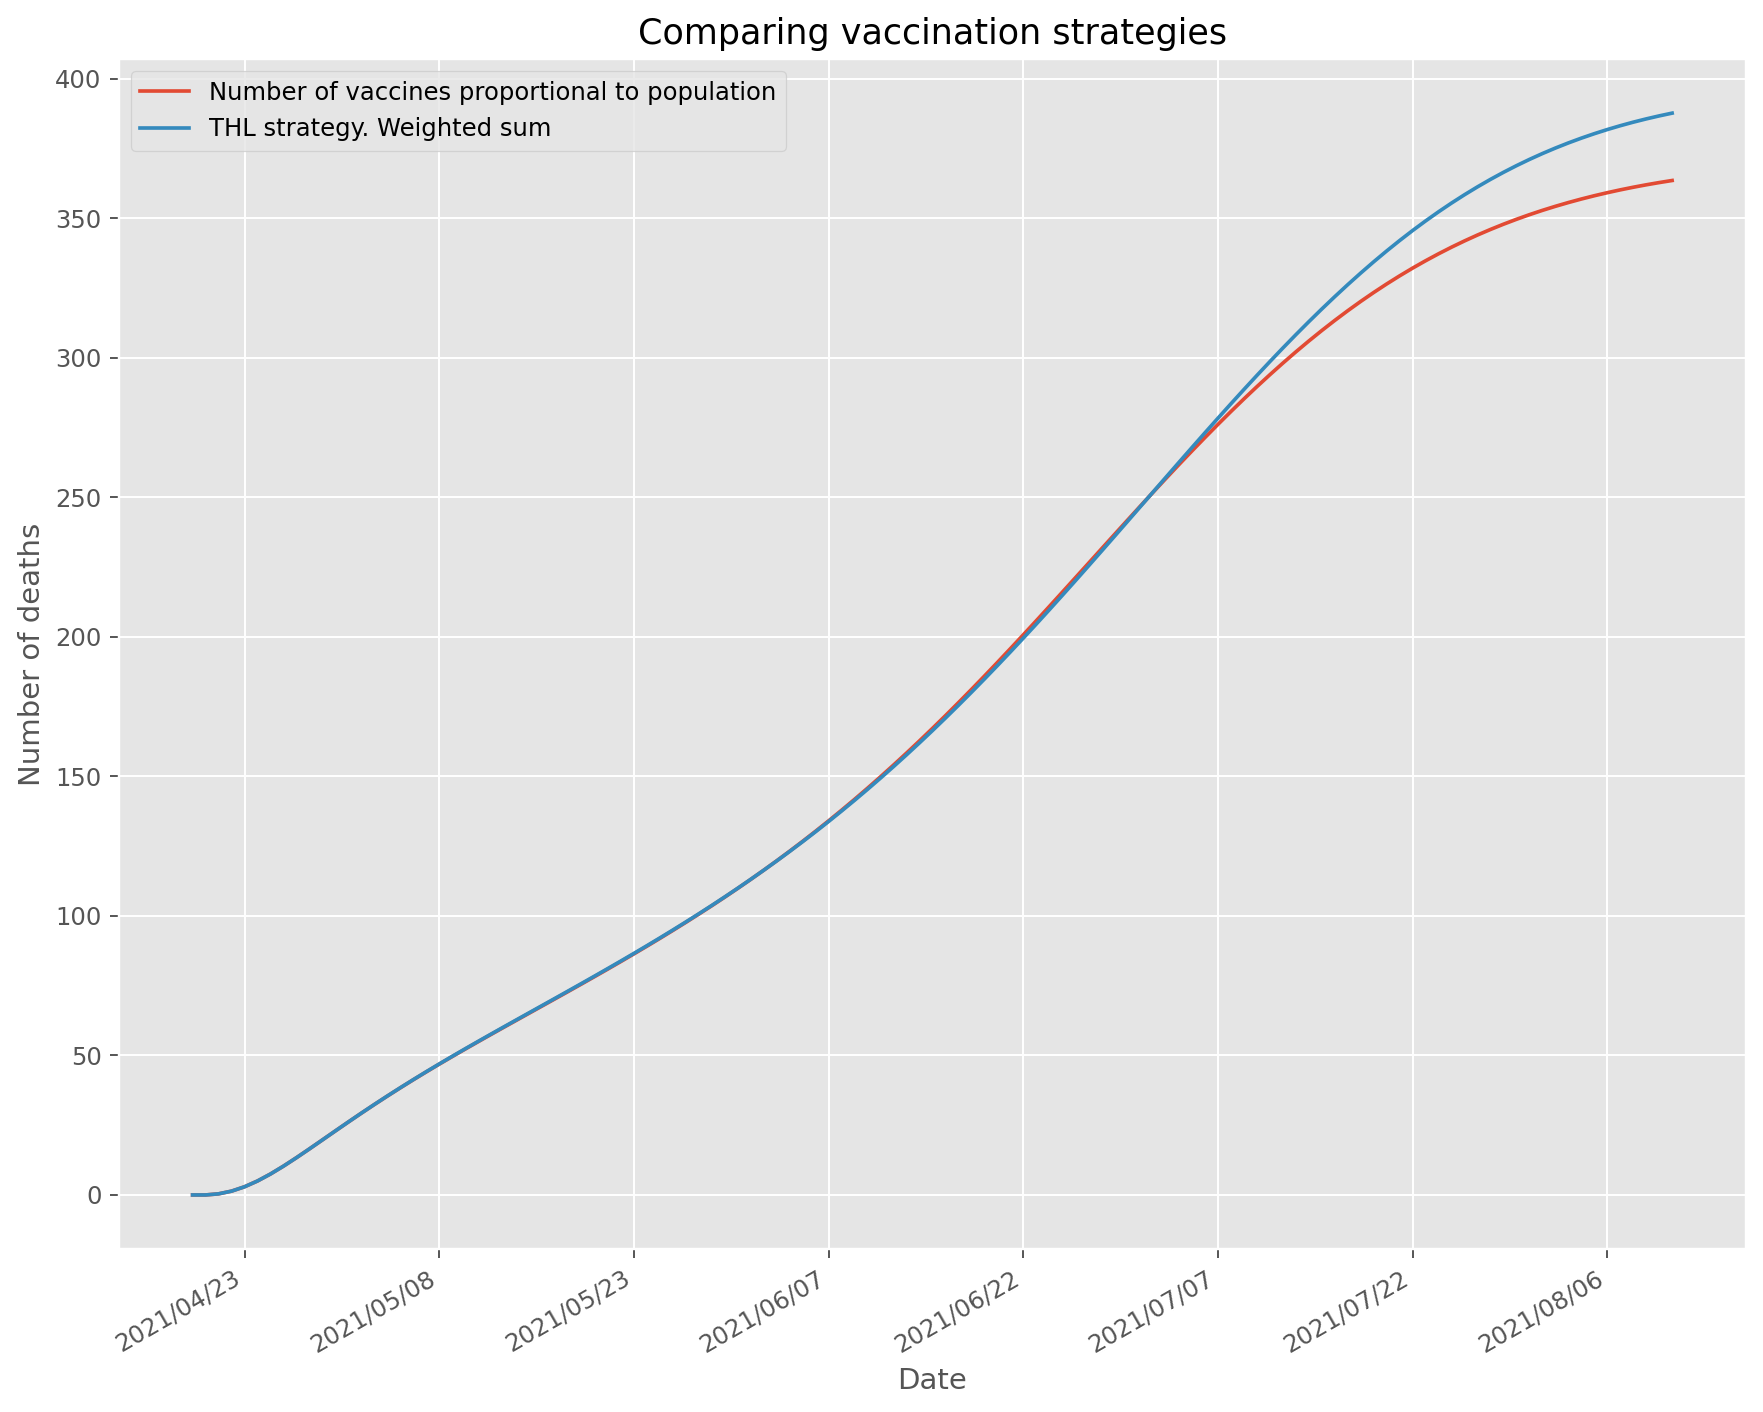

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_compare_strategies(ax=ax, D_g=D_g_plot, D_g_thl=D_g_thl_plot, t0=t0, T=T)

fig.autofmt_xdate()

In [19]:
mask = [True, False, True]
a = np.zeros((3))
b = np.array([2, 3])
a[mask] = b
a

array([2., 0., 3.])